# Figure1 a-d, i

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Data is of class data.frame. Coercing to dgCMatrix.”
Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  TRBC1, GZMA, LTB, KLRB1, CD69, CCL5, TIGIT, NKG7, ICOS, CD27 
	   RGS1, GZMB, JUN, AC092580.4, TNFRSF18, CD8A, HSPA8, FKBP11, HMGB2, PRF1 
	   GZMH, GZMK, CXCR6, IFNG, CTSW, GPR171, LAG3, BATF, CD8B, GNLY 
Negative:  FCER1G, CXCL8, TYROBP, IL1B, AIF1, PLAUR, LYZ, CXCL2, SOD2, S100A9 
	   G0S2, CTSB, CD68, C15orf48, CD14, CST3, FCGR2A, BCL2A1, CCL3, FTL 
	   IER3, NPC2, CXCL3, CCL3L3, GLUL, IL1RN, SERPINA1, PSAP, EREG, CTSL 
PC_ 2 
Positive:  CALD1, SPARC, IGFBP7, COL6A2, NNMT, BGN, C1R, C1S, COL1A2, RARRES2 
	   COL6A1, COL3A1, COL1A1, TPM2, MYL9, AEBP1, PTRF, FSTL1, DCN, MGP 
	   MMP2, LUM, THY1, CAV1, TAGLN, PRKCDBP, COL6A3, IGFBP4, SOD3, CNN3 
Negative:  CD74, BCL2A1, HLA-DRA, HLA-DPB1, HLA-DPA1, FCER

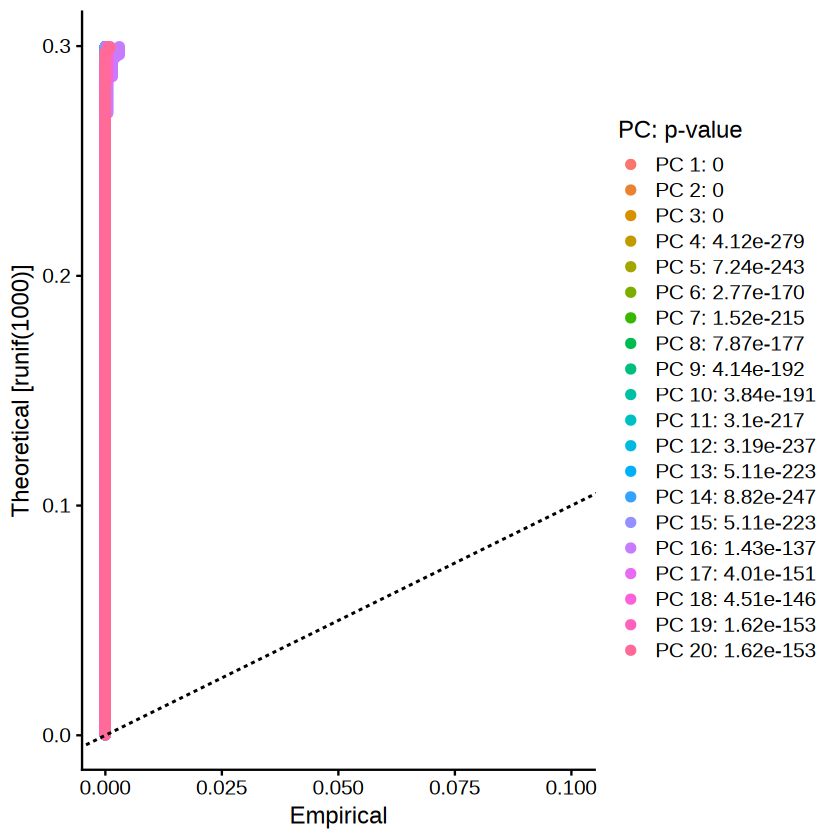

Warning message:
“Removed 28000 rows containing missing values or values outside the scale range
(`geom_point()`).”
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 26343
Number of edges: 902418

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9231
Number of communities: 17
Elapsed time: 5 seconds


15:08:24 UMAP embedding parameters a = 0.9922 b = 1.112

15:08:24 Read 26343 rows and found 20 numeric columns

15:08:24 Using Annoy for neighbor search, n_neighbors = 30

15:08:24 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:08:26 Writing NN index file to temp file /tmp/Rtmp1iIZSu/file338a5f780f6c

15:08:26 Searching Annoy index using 1 thread, search_k = 3000

15:08:35 Annoy recall = 100%

15:08:36 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

15:08:38 Initializing from normalized Laplacian + noise (using RSpectra)

15:08:42 Commencing optimization for 200 epochs, with 1150308 positive edges

15:08:42 Using rng type: pcg

15:09:12 Optimization finished



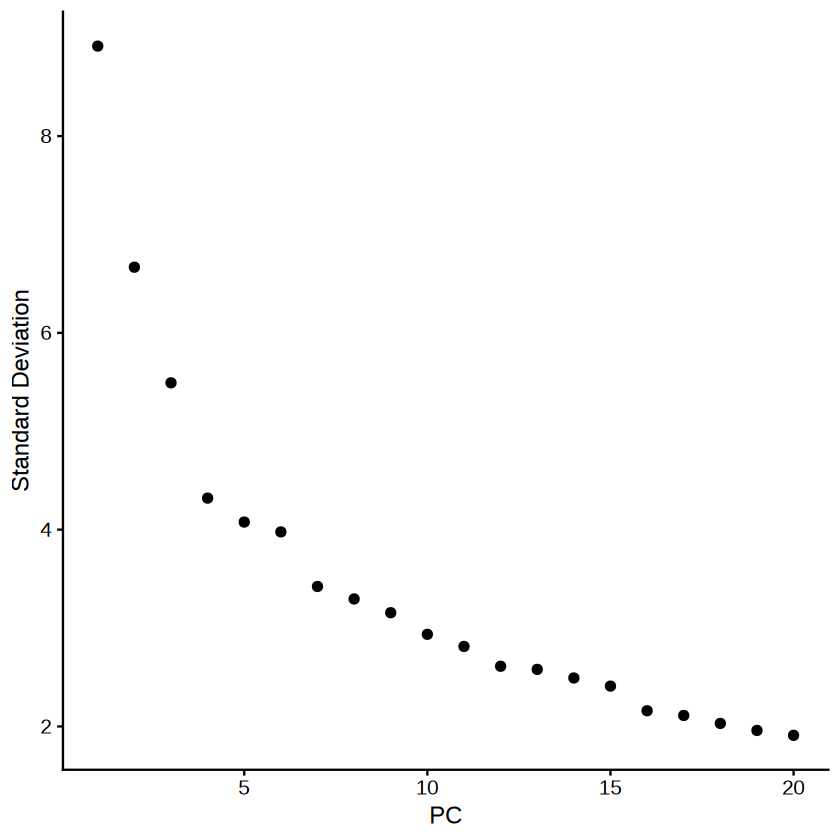

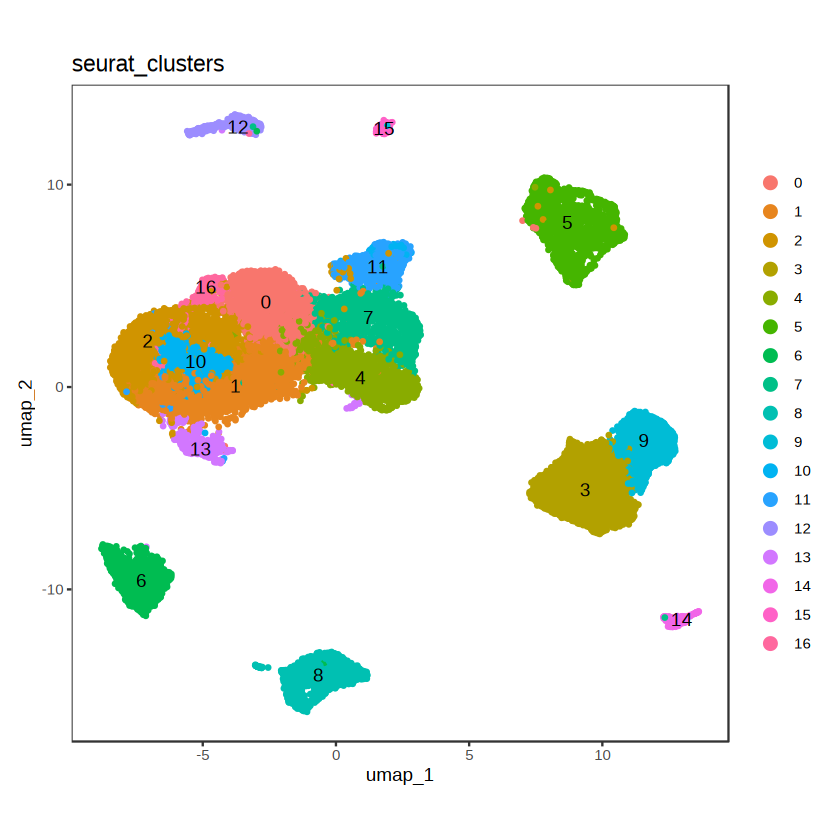

Calculating cluster T_cells

Calculating cluster Monocyte

Calculating cluster B_cell

Calculating cluster Epithelial_cells

Calculating cluster Macrophage

Calculating cluster NK_cell

Calculating cluster Tissue_stem_cells

Calculating cluster Endothelial_cells

Warning message in DoHeatmap(Tumor_filter, features = top_genes):
“The following features were omitted as they were not found in the scale.data slot for the RNA assay: MYCT1, NOVA2, RERG, MRGPRF, CD209, CD2, TRAC, CD6, CD5, CD28”


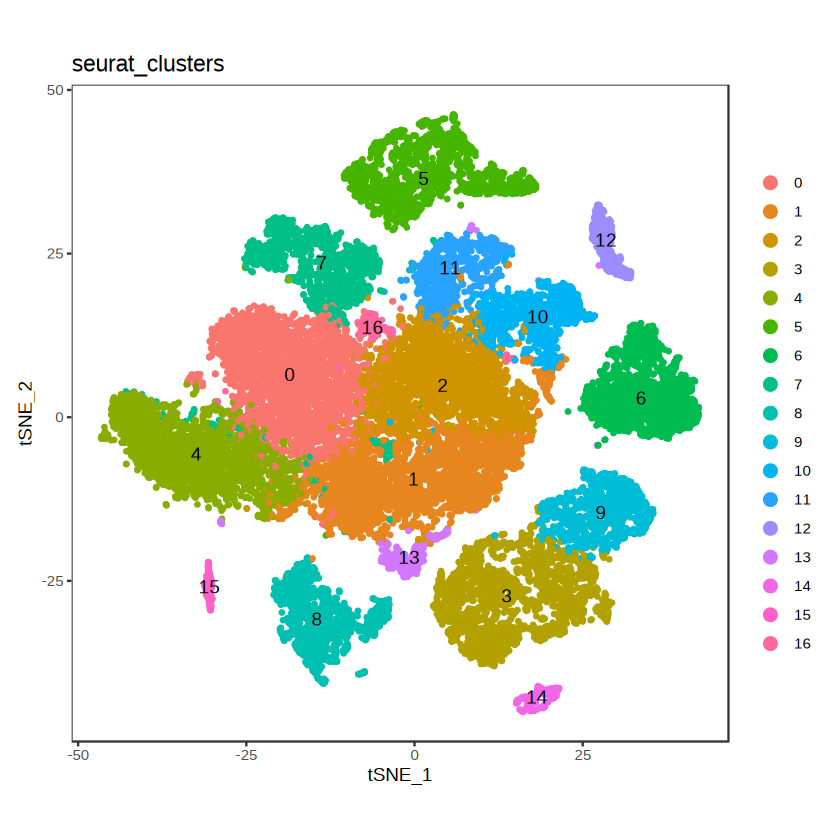

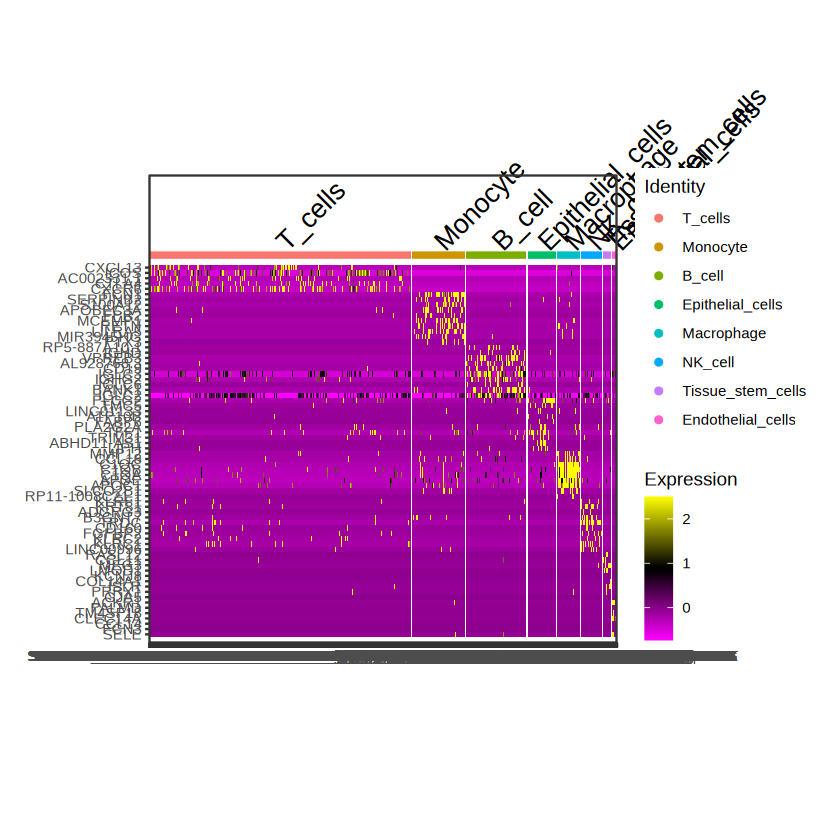

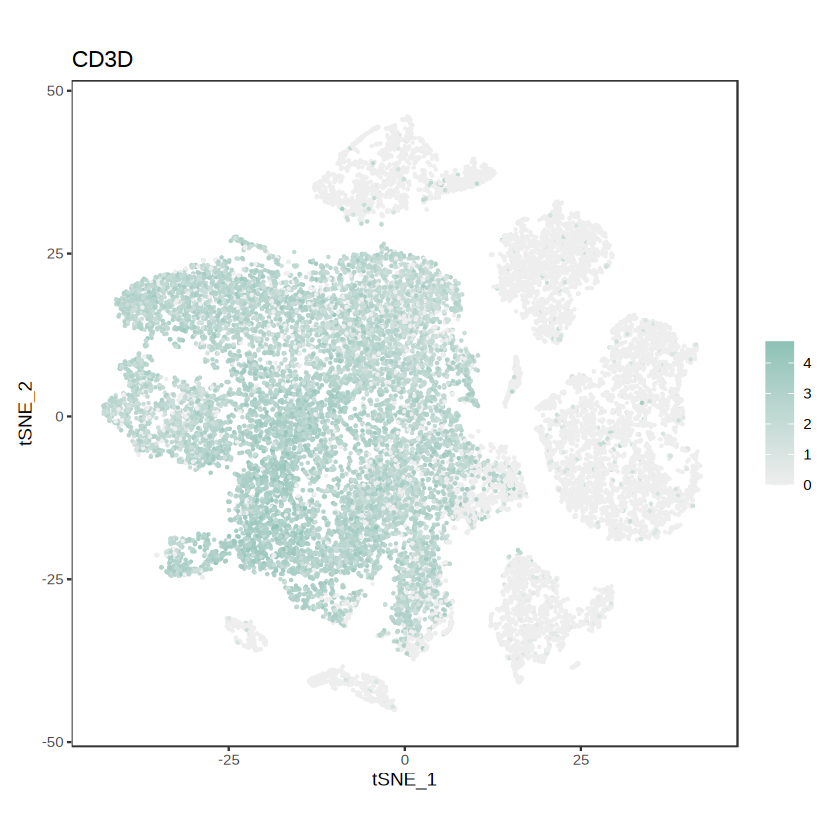

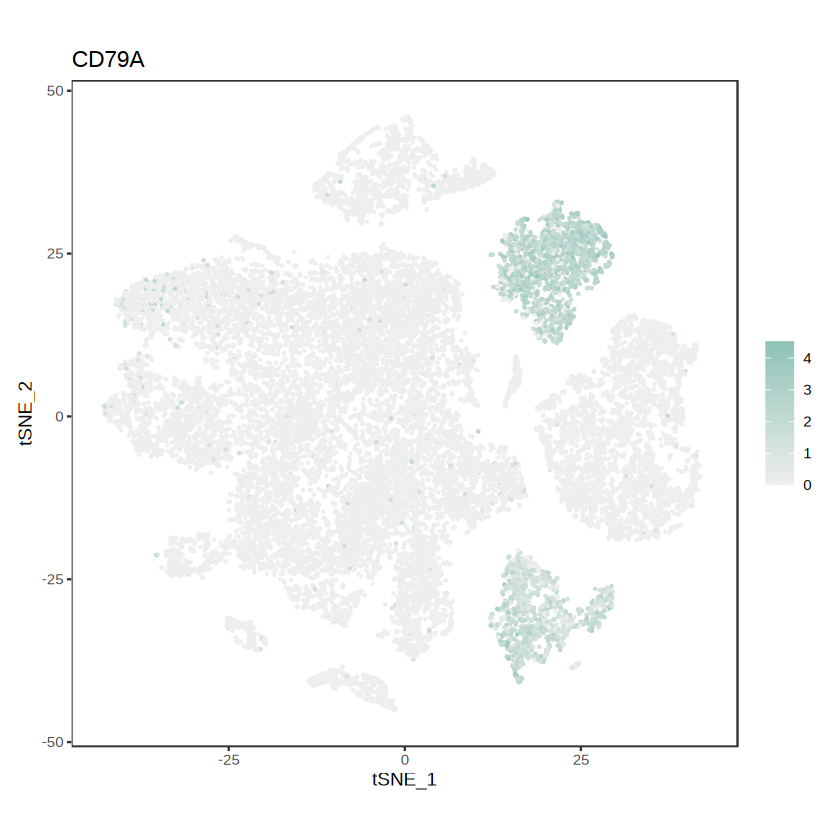

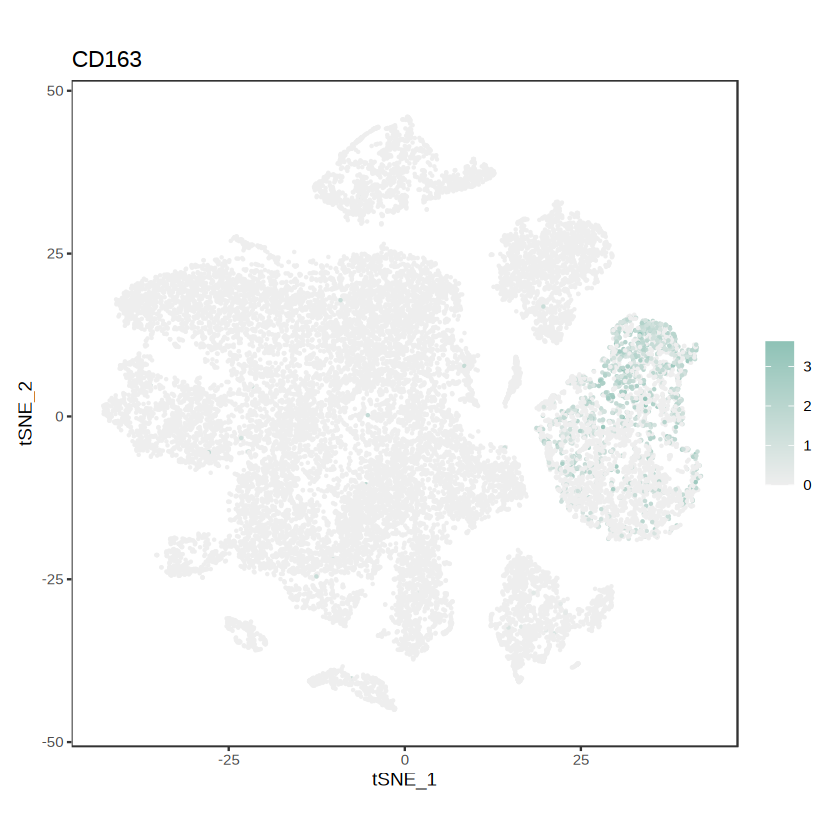

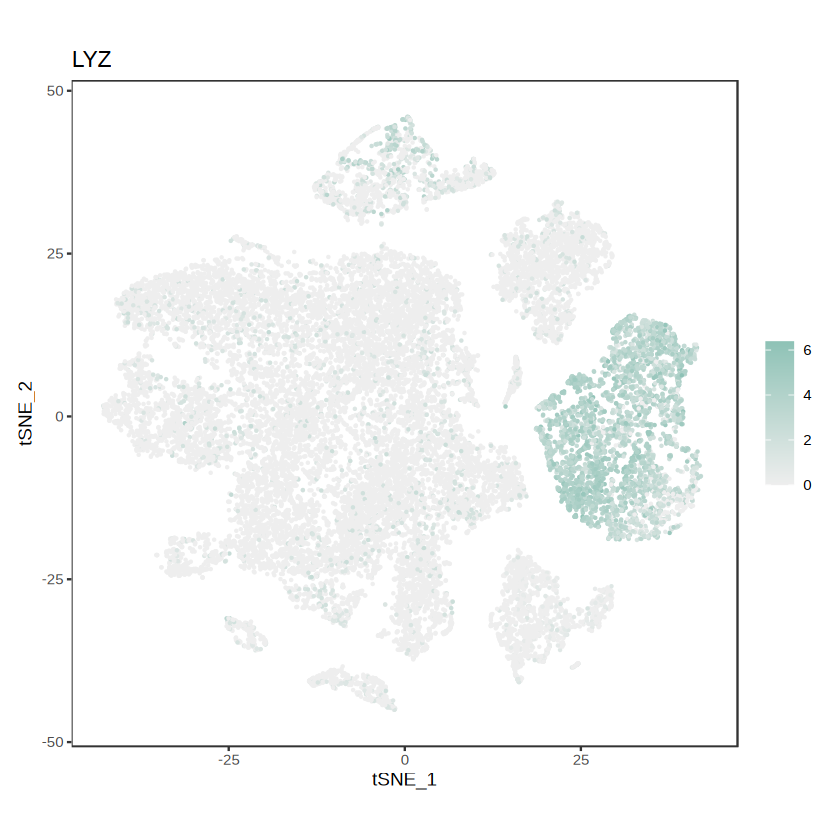

agg_record_720147529 
                   2

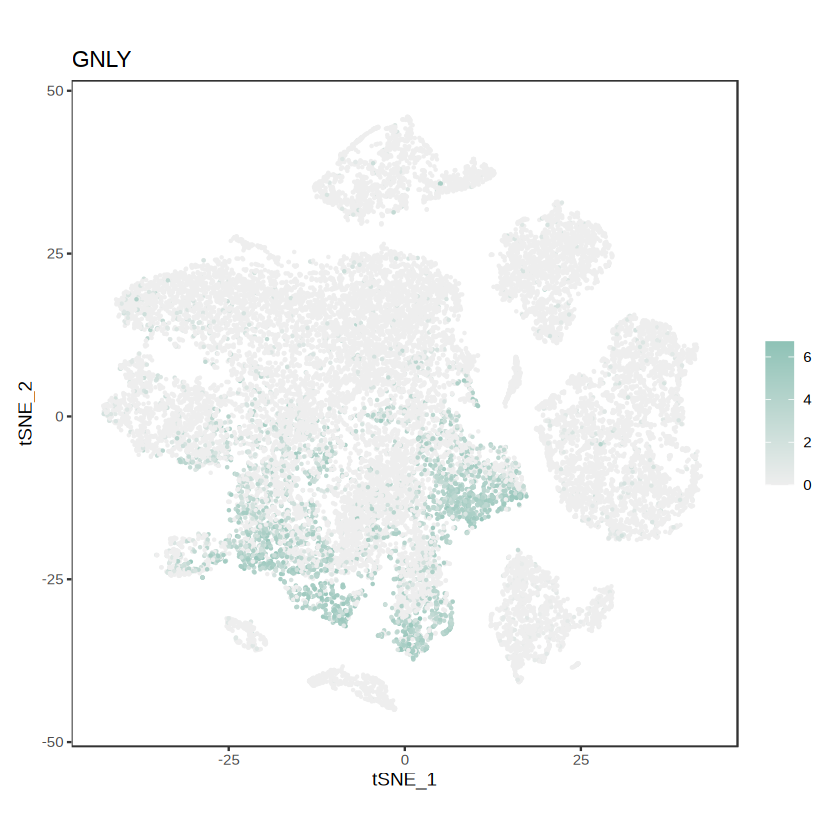

In [4]:
############################################################
## Load libraries
############################################################
library(Seurat)
library(dplyr)
library(SingleR)
library(celldex)
library(ggplot2)
library(gridExtra)

set.seed(1234)

############################################################
## 1. Load raw data
############################################################
RAW_DATA <- read.table(
  gzfile("/public/hubCache/workshop/sunhy/projects/song_project/project5/Fig1/scRNA/data_download/GSE132465/GSE132465_GEO_processed_CRC_10X_raw_UMI_count_matrix.txt.gz"),
  header = TRUE,
  row.names = 1,
  check.names = FALSE
)

OBJECT <- CreateSeuratObject(
  RAW_DATA,
  project = "GSE132465",
  min.cells = 3,
  min.features = 200
)

OBJECT$sample <- ifelse(substr(OBJECT$orig.ident, 7, 7) == "T", "Tumor", "Normal")
Tumor <- subset(OBJECT, sample == "Tumor")

############################################################
## 2. Quality control (QC)
############################################################
mt.genes <- grep("^(MT-|mt-|MT\\.)", rownames(Tumor), value = TRUE)
Tumor[["percent.mt"]] <- PercentageFeatureSet(Tumor, features = mt.genes)

exclude_samples <- c("SMC16.T", "SMC18.T", "SMC21.T", "SMC22.T")
Tumor_filter <- subset(Tumor, subset = !(orig.ident %in% exclude_samples))

Tumor_filter <- subset(
  Tumor_filter,
  subset = nFeature_RNA > 500 &
    nFeature_RNA < 2000 &
    percent.mt < 10
)

############################################################
## 3. Normalization + HVGs
############################################################
Tumor_filter <- NormalizeData(Tumor_filter)
Tumor_filter <- FindVariableFeatures(Tumor_filter, selection.method = "vst", nfeatures = 2000)
Tumor_filter <- ScaleData(Tumor_filter)

############################################################
## 4. PCA, JackStraw significance test
############################################################
Tumor_filter <- RunPCA(Tumor_filter, features = VariableFeatures(Tumor_filter))

# JackStraw significance test
Tumor_filter <- JackStraw(Tumor_filter, num.replicate = 100)
Tumor_filter <- ScoreJackStraw(Tumor_filter, dims = 1:20)

p_jack <- JackStrawPlot(Tumor_filter, dims = 1:20)
p_elbow <- ElbowPlot(Tumor_filter)

p_jack
p_elbow

ggsave("PCA_JackStraw_plot.pdf", p_jack, width = 7, height = 7)
ggsave("PCA_Elbow_plot.pdf", p_elbow, width = 6, height = 6)

############################################################
## 5. Clustering & UMAP/TSNE
############################################################
Tumor_filter <- FindNeighbors(Tumor_filter, dims = 1:20)
Tumor_filter <- FindClusters(Tumor_filter, resolution = 0.5)

Tumor_filter <- RunUMAP(Tumor_filter, dims = 1:20)
Tumor_filter <- RunTSNE(Tumor_filter, dims = 1:20)

theme_global <- theme_bw() +
  theme(panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        aspect.ratio = 1)

UMAP_no_label <- DimPlot(
  Tumor_filter, reduction = "umap",
  group.by = "seurat_clusters", label = TRUE, pt.size = 0.7
) + theme_global

TSNE_no_label <- DimPlot(
  Tumor_filter, reduction = "tsne",
  group.by = "seurat_clusters", label = TRUE, pt.size = 0.7
) + theme_global

UMAP_no_label
TSNE_no_label

ggsave("umap_no_label.pdf", UMAP_no_label, width = 7, height = 7)
ggsave("tsne_no_label.pdf", TSNE_no_label, width = 7, height = 7)

############################################################
## 6. Load annotated Seurat object
############################################################
Tumor_filter <- readRDS("/public/hubCache/workshop/sunhy/projects/song_project/project5/Fig1/scRNA/variable_gene_dim_annotation_immugene/GSE132465_Tumor_filter_anno.RDS")

############################################################
## 7. Marker gene analysis
############################################################
Tumor_filter_marker <- FindAllMarkers(
  Tumor_filter,
  only.pos = FALSE,
  min.pct = 0.1,
  logfc.threshold = 0.25
)

TOP10 <- Tumor_filter_marker %>%
  group_by(cluster) %>%
  slice_max(order_by = avg_log2FC, n = 10) %>%
  ungroup()

write.csv(Tumor_filter_marker, "Tumor_filter_marker.csv", row.names = FALSE)

top_genes <- unique(TOP10$gene)
Heatmap10 <- DoHeatmap(Tumor_filter, features = top_genes) + theme_global

Heatmap10
ggsave("DoHeatmap_10.pdf", Heatmap10, width = 12, height = 6)

############################################################
## 8. Immune marker FeaturePlot (cell type check)
############################################################
immune_genes <- c("CD3D", "CD79A", "CD163", "LYZ", "GNLY")
plot_list <- list()

for (g in immune_genes) {
  p <- FeaturePlot(
    Tumor_filter,
    features = g,
    cols = c("#eeeeee", "#8ec2b6"),
    reduction = "tsne"
  ) + theme_global
  print(p)   
  plot_list[[g]] <- p
}

# Save as PDF
pdf("immucell_marker_tsne.pdf", width = 20)
for (g in immune_genes) {
  grid.arrange(plot_list[[g]])
}
dev.off()


# Figure1 e-h

In [ ]:
library(dplyr)
library(Seurat)
library(patchwork)
library(monocle)

### 1. Load Seurat object
Tumor_filter_anno <- readRDS("/public/hubCache/workshop/sunhy/projects/song_project/project5/Fig1/scRNA/variable_gene_dim_annotation_immugene/GSE132465_Tumor_filter.RDS")

### 2. Prepare input matrix for Monocle
expr_matrix <- as(as.matrix(Tumor_filter_anno@assays$RNA@counts), "sparseMatrix")
p_data <- Tumor_filter_anno@meta.data
f_data <- data.frame(
  gene_short_name = rownames(Tumor_filter_anno),
  row.names = rownames(Tumor_filter_anno)
)

pd <- new("AnnotatedDataFrame", data = p_data)
fd <- new("AnnotatedDataFrame", data = f_data)

### 3. Construct CellDataSet
cds <- newCellDataSet(
  expr_matrix,
  phenoData = pd,
  featureData = fd,
  lowerDetectionLimit = 0.5,
  expressionFamily = negbinomial.size()
)

cds <- estimateSizeFactors(cds)
cds <- estimateDispersions(cds)

### 4. Ordering genes (variable genes)
express_genes <- VariableFeatures(Tumor_filter_anno)
cds <- setOrderingFilter(cds, express_genes)

# Display ordering genes plot
p_order_genes <- plot_ordering_genes(cds)
print(p_order_genes)
ggsave("Monocle_ordering_genes.pdf", p_order_genes, width = 8, height = 6)

### 5. Differential gene test for trajectory ordering
diff <- differentialGeneTest(
  cds[express_genes, ],
  fullModelFormulaStr = "~cluster.label",
  cores = 1
)

deg <- subset(diff, qval < 0.01)
deg <- deg[order(deg$qval, decreasing = FALSE), ]
ordergene <- rownames(deg)

### 6. Set final ordering genes
cds <- setOrderingFilter(cds, ordergene)
p_order_final <- plot_ordering_genes(cds)
print(p_order_final)
ggsave("Monocle_ordering_genes_final.pdf", p_order_final, width = 8, height = 6)

### 7. Reduce dimension & build trajectory
cds <- reduceDimension(cds, max_components = 2, method = "DDRTree")
cds <- orderCells(cds)

### 8. Plots
P1 <- plot_cell_trajectory(cds, color_by = "Pseudotime", size = 1, show_backbone = TRUE)
P2 <- plot_cell_trajectory(cds, color_by = "cluster.label", size = 1, show_backbone = TRUE)
P3 <- plot_cell_trajectory(cds, color_by = "State", size = 1, show_backbone = TRUE)
P4 <- plot_cell_trajectory(cds, color_by = "seurat_clusters")

# Display plots in notebook
print(P1)
print(P2)
print(P3)
print(P4)

# Save each plot as PDF
ggsave("Monocle_Pseudotime.pdf", P1, width = 8, height = 6)
ggsave("Monocle_cell_type.pdf", P2, width = 8, height = 6)
ggsave("Monocle_State.pdf", P3, width = 8, height = 6)
ggsave("Monocle_seurat_clusters.pdf", P4, width = 8, height = 6)


In [ ]:
### 8. Plots
P1 <- plot_cell_trajectory(cds, color_by = "Pseudotime", size = 1, show_backbone = TRUE)
P2 <- plot_cell_trajectory(cds, color_by = "cluster.label", size = 1, show_backbone = TRUE)
P3 <- plot_cell_trajectory(cds, color_by = "State", size = 1, show_backbone = TRUE)
P4 <- plot_cell_trajectory(cds, color_by = "seurat_clusters")

pdf("Monocle_Pseudotime.pdf", width = 8, height = 6)
print(P1)
dev.off()

pdf("Monocle_cluster_label.pdf", width = 8, height = 6)
print(P2)
dev.off()

pdf("Monocle_State.pdf", width = 8, height = 6)
print(P3)
dev.off()

pdf("Monocle_seurat_clusters.pdf", width = 8, height = 6)
print(P4)
dev.off()



png 
  2

png 
  2

png 
  2

png 
  2